In [1]:
import os
import sys
import re
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from Bio import SeqIO
from datetime import datetime
from numpy.random import randint
import torch
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader

import matplotlib
import matplotlib.pyplot as plt

In [2]:
k = 7

In [3]:
from HDF5dataset import HDF5Dataset
from WeightsCreator import make_weights_for_balanced_classes

In [4]:
inputFeatures = int((4**k) / 2)
layer_array = [512, 512, 256, 256]
outputSize = 2
momentum = 0.4
dropoutProb = 0.5
batchSize = 200
num_epochs = 20
opt_func = torch.optim.Adam
weight_decay = 1e-5
lr = 0.001

In [5]:
trainingDataset = HDF5Dataset(
    '/home/chamikanandasiri/Test/DNAML_mixed_40000_dataset.h5', True)
datasetsize = len(trainingDataset)
train_size = int(0.8 * len(trainingDataset))
val_size = len(trainingDataset) - train_size


In [6]:
train_ds, val_ds = random_split(trainingDataset, [train_size, val_size])

In [7]:
# rtye = torch.tensor(train_ds.indices)

In [8]:
# valspl = train_ds.dataset.get_label_values(rtye)

In [9]:
# weights = make_weights_for_balanced_classes(outputSize, valspl)
#weights = make_weights_for_balanced_classes(outputSize, torch.randint(0, 10, (len(train_ds),)))

In [10]:
# weights = torch.DoubleTensor(weights.double())
# sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, datasetsize)

In [11]:
# train_dl = DataLoader(train_ds, batchSize, shuffle=False, num_workers=6, pin_memory=True, sampler=sampler)
train_dl = DataLoader(train_ds, batchSize, shuffle=True, num_workers=6, pin_memory=True)
val_dl = DataLoader(val_ds, batchSize, num_workers=4, pin_memory=True)

In [12]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    # optimizer = opt_func(model.parameters(), lr, weight_decay)
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

class Model(nn.Module):
    def __init__(self, in_size, layer_array = [512, 512, 256, 256], out_size = 28):
        super().__init__()
        self.network = nn.Sequential(
          nn.Linear(in_size, layer_array[0]),
          nn.ReLU(),
          # nn.Dropout(dropoutProb),
          nn.Linear(layer_array[0], layer_array[1]),
          nn.ReLU(),
          # nn.Dropout(dropoutProb),
          nn.Linear(layer_array[1], layer_array[2]),
          nn.ReLU(),
          # nn.Dropout(dropoutProb),
          nn.Linear(layer_array[2], layer_array[3]),
          nn.ReLU(),
          # nn.Dropout(dropoutProb),
          nn.Linear(layer_array[3], out_size)
        )
        
    def forward(self, xb):
        softmax = nn.LogSoftmax(dim=0)
        return softmax(self.network(xb))

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = nn.functional.nll_loss(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = nn.functional.nll_loss(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

def predict_image(value, model):
  xb = value
  # //:TODO Check torch.stack
  # xb = torch.stack(value)
  yb = model(xb)
  _, preds  = torch.max(yb, dim=0)
  return preds


In [13]:
model = Model(inputFeatures, layer_array, outputSize)
model

Model(
  (network): Sequential(
    (0): Linear(in_features=8192, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [14]:
model.double()
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], val_loss: 5.2983, val_acc: 0.5028
Epoch [1], val_loss: 5.2983, val_acc: 0.5137
Epoch [2], val_loss: 5.2983, val_acc: 0.4795
Epoch [3], val_loss: 5.2983, val_acc: 0.4891
Epoch [4], val_loss: 5.2984, val_acc: 0.4846
Epoch [5], val_loss: 5.2983, val_acc: 0.5185
Epoch [6], val_loss: 5.2988, val_acc: 0.4760
Epoch [7], val_loss: 5.2982, val_acc: 0.5347
Epoch [8], val_loss: 5.2990, val_acc: 0.4894
Epoch [9], val_loss: 5.2968, val_acc: 0.5595
Epoch [10], val_loss: 5.3029, val_acc: 0.3623
Epoch [11], val_loss: 5.3029, val_acc: 0.3476
Epoch [12], val_loss: 5.3114, val_acc: 0.3462
Epoch [13], val_loss: 5.3232, val_acc: 0.3071
Epoch [14], val_loss: 5.3292, val_acc: 0.2890
Epoch [15], val_loss: 5.3247, val_acc: 0.2959
Epoch [16], val_loss: 5.3630, val_acc: 0.2912
Epoch [17], val_loss: 5.3626, val_acc: 0.2715
Epoch [18], val_loss: 5.3435, val_acc: 0.2682
Epoch [19], val_loss: 5.3655, val_acc: 0.2714


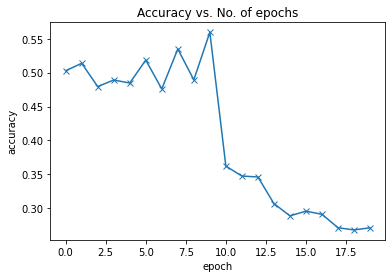

In [15]:
plot_accuracies(history)

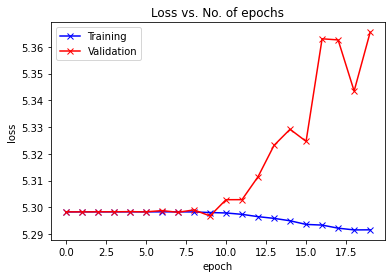

In [16]:
plot_losses(history)

In [29]:
testingDataset = HDF5Dataset(
    '/home/chamikanandasiri/Test/Plasmid(testing0.008)Dataset.h5', False)

In [30]:
test_dl = DataLoader(testingDataset, batchSize, num_workers=4, pin_memory=True)


In [31]:
cor = []
incor = []
for i in range(len(testingDataset)):
    prediction = predict_image(testingDataset[i][0], model)
    label = testingDataset[i][1]
    if( prediction== label):
        cor.append([label,prediction])
    else:
        incor.append([label,prediction])

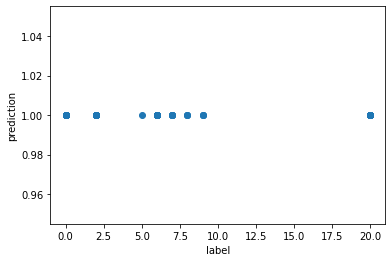

In [32]:
correct_df = pd.DataFrame(cor, columns=['label','prediction'])
incorrect_df = pd.DataFrame(incor, columns=['label','prediction'])
plt.scatter(incorrect_df['label'],incorrect_df['prediction'])
plt.xlabel('label')
plt.ylabel('prediction')
plt.show()

In [33]:
correct_df.prediction.value_counts()

tensor(1)    73
Name: prediction, dtype: int64

In [34]:
len(correct_df)

73

In [35]:
correct_df

,label,prediction
0,tensor(1),tensor(1)
1,tensor(1),tensor(1)
2,tensor(1),tensor(1)
3,tensor(1),tensor(1)
4,tensor(1),tensor(1)
...,...,...
68,tensor(1),tensor(1)
69,tensor(1),tensor(1)
70,tensor(1),tensor(1)
71,tensor(1),tensor(1)


In [36]:
len(incorrect_df)

1479

In [37]:
incorrect_df.prediction.value_counts()

tensor(1)    109
tensor(1)    105
tensor(1)     99
tensor(1)     97
tensor(1)     95
tensor(1)     94
tensor(1)     93
tensor(1)     91
tensor(1)     90
tensor(1)     90
tensor(1)     90
tensor(1)     88
tensor(1)     86
tensor(1)     85
tensor(1)     85
tensor(1)     81
tensor(1)      1
Name: prediction, dtype: int64

In [24]:
incorrect_df.to_csv('Incorrect.csv',index=False)

In [25]:
incorrect_df.prediction.value_counts()

tensor(1)    143
tensor(1)    126
tensor(1)    121
tensor(1)    117
Name: prediction, dtype: int64

In [26]:
incorrect_df.head(10)

,label,prediction
0,tensor(0),tensor(1)
1,tensor(0),tensor(1)
2,tensor(0),tensor(1)
3,tensor(0),tensor(1)
4,tensor(0),tensor(1)
5,tensor(0),tensor(1)
6,tensor(6),tensor(1)
7,tensor(0),tensor(1)
8,tensor(0),tensor(1)
9,tensor(0),tensor(1)


In [27]:
predict_image(torch.from_numpy(train_ds([0][0]), model) , train_ds([0][1]))

TypeError: 'Subset' object is not callable

In [ ]:
classdf = pd.read_csv('/home/chamikanandasiri/Datasets/DNAML_Plasmid/SplitPlasmidDatasetInfo.csv')

In [ ]:
classdf.label_number.value_counts()